# Analysis of the consumption measurements 
#### Measurements are made on the DNS PC with external and software estimations

The goal of this notebook is to explore and analyze the measurements, identify correlations between them, and gain insights. Based on this exploration, we will develop a model to disaggregate the external measurements and accurately profile the consumption of each individual component.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Import all csv file

In [2]:
DATA_PATH = "../data/300_DoH_1"

In [3]:
cpu_power = pd.read_csv(f"{DATA_PATH}/measures/cpu_power.csv")
# convert Time_Of_Day_Seconds to int
cpu_power["datetime"] = pd.to_datetime(cpu_power["Time_Of_Day_Seconds"], unit='s')
cpu_power.drop(columns=["Time_Of_Day_Seconds"], inplace=True)
cpu_power.head()

,Avg_MHz,Busy%,Bzy_MHz,LLCkRPS,LLC%hit,C6%,CoreTmp,PkgTmp,PkgWatt,CorWatt,datetime
0,128,5.01,2561,7973,0.0,94.05,44,44,5.24,1.78,2026-02-16 15:42:54.792577982
1,51,2.39,2131,4388,0.0,97.38,39,39,4.42,1.00,2026-02-16 15:42:55.793097019
2,130,5.18,2517,8006,0.0,94.37,39,39,5.26,1.79,2026-02-16 15:42:56.793667078
3,79,3.25,2447,5930,0.0,96.37,40,40,4.73,1.29,2026-02-16 15:42:57.794118881
4,128,5.21,2468,7985,0.0,94.34,35,35,5.27,1.80,2026-02-16 15:42:58.794805050


In [4]:
io_power = pd.read_csv(f"{DATA_PATH}/measures/io_power.csv")
io_power["datetime"] = pd.to_datetime(io_power["timestamp"], unit='s')
io_power.drop(columns=["timestamp"], inplace=True)
io_power.head()

,read_kB,write_kB,total_kB,datetime
0,0,84,84,2026-02-16 15:42:54
1,0,44,44,2026-02-16 15:42:55
2,0,8,8,2026-02-16 15:42:56
3,0,0,0,2026-02-16 15:42:57
4,0,0,0,2026-02-16 15:42:58


In [5]:
nic_power = pd.read_csv(f"{DATA_PATH}/measures/nic_power.csv")
nic_power["datetime"] = pd.to_datetime(nic_power["timestamp"], unit='s')
nic_power.drop(columns=["timestamp"], inplace=True)
nic_power.head()

,rx_bytes,tx_bytes,total_bytes,datetime
0,4050,3628,7678,2026-02-16 15:42:54
1,4320,3482,7802,2026-02-16 15:42:55
2,4150,3616,7766,2026-02-16 15:42:56
3,4316,3988,8304,2026-02-16 15:42:57
4,4621,3584,8205,2026-02-16 15:42:58


In [6]:
ram_power = pd.read_csv(f"{DATA_PATH}/measures/ram_power.csv")
ram_power["datetime"] = pd.to_datetime(ram_power["timestamp"], unit='s')
ram_power.drop(columns=["timestamp"], inplace=True)
ram_power.head()

,LLC-loads,LLC-stores,datetime
0,3055166,678258,2026-02-16 15:42:53
1,1985207,417749,2026-02-16 15:42:54
2,2806552,616651,2026-02-16 15:42:55
3,1938352,432190,2026-02-16 15:42:56
4,2869223,640672,2026-02-16 15:42:57


In [7]:
yoctowatt = pd.read_csv(f"{DATA_PATH}/measures/yoctowatt.csv")
yoctowatt["datetime"] = pd.to_datetime(yoctowatt["timestamp_unix"], unit='s')
yoctowatt = yoctowatt.drop(columns=["reportFrequency_effective", "timestamp_iso", "timestamp_unix"])
yoctowatt.head()

,watts,datetime
0,37.371,2026-02-16 15:42:53.711999893
1,37.371,2026-02-16 15:42:53.721999884
2,37.371,2026-02-16 15:42:53.732000113
3,37.371,2026-02-16 15:42:53.742000103
4,37.371,2026-02-16 15:42:53.752000093


## Import log files

In [8]:
def import_log_file(file_path, offset_seconds=0, offset_date=None):
    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        log_df = pd.DataFrame({"raw": f.read().splitlines()})
        
    pattern = r'^(?P<date>\d{2}-[A-Za-z]{3}-\d{4})\s+(?P<time>\d{2}:\d{2}:\d{2}\.\d+).*$'
    if offset_date:
        pattern = r'^(?P<time>\d{2}:\d{2}:\d{2}\.\d+).*$'
    
    log_df = log_df["raw"].str.extract(pattern)
    
    if offset_date:
        log_df["date"] = offset_date.strftime("%d-%b-%Y")

    log_df["datetime"] = pd.to_datetime(log_df["date"] + " " + log_df["time"], format="%d-%b-%Y %H:%M:%S.%f")
    log_df["datetime"] = log_df["datetime"] + pd.to_timedelta(-offset_seconds, unit='s')
    log_df = log_df.drop(columns=["date", "time"])

    log_df.dropna(inplace=True)
    if offset_date is None:
        date_offset = log_df["datetime"].iloc[0].date()
    
    log_df = log_df.set_index("datetime").sort_index()
    
    if offset_date:
        return log_df
    return log_df,date_offset

Logs are one hour ahead so offset_seconds is 3600

In [9]:
bind_queries_captured_logs, date_offset = import_log_file(f"{DATA_PATH}/logs/bind_queries_captured.log", offset_seconds=3600)
bind_queries_captured_logs.head()

""
datetime
2026-02-16 15:42:54.672
2026-02-16 15:42:55.672
2026-02-16 15:42:56.676
2026-02-16 15:42:57.676
2026-02-16 15:42:58.680


In [10]:
date_offset

datetime.date(2026, 2, 16)

In [11]:
dns_doh_log = import_log_file(f"{DATA_PATH}/logs/dns_doh.log", offset_seconds=3600, offset_date=date_offset)
dns_doh_log.head()

""
datetime
2026-02-16 15:42:54.673045
2026-02-16 15:42:54.673104
2026-02-16 15:42:54.673150
2026-02-16 15:42:54.673208
2026-02-16 15:42:54.673640


In [12]:
dns_tcp_log = import_log_file(f"{DATA_PATH}/logs/dns_tcp.log", offset_seconds=3600, offset_date=date_offset)
dns_tcp_log.head()

""
datetime


In [13]:
dns_udp_log = import_log_file(f"{DATA_PATH}/logs/dns_udp.log", offset_seconds=3600, offset_date=date_offset)
dns_udp_log.head()

""
datetime
2026-02-16 15:42:53.752482
2026-02-16 15:42:53.752490
2026-02-16 15:42:53.752492
2026-02-16 15:42:53.752496
2026-02-16 15:42:53.752789


<Axes: title={'center': 'DNS Traffic Comparison (QPS)'}, xlabel='datetime'>

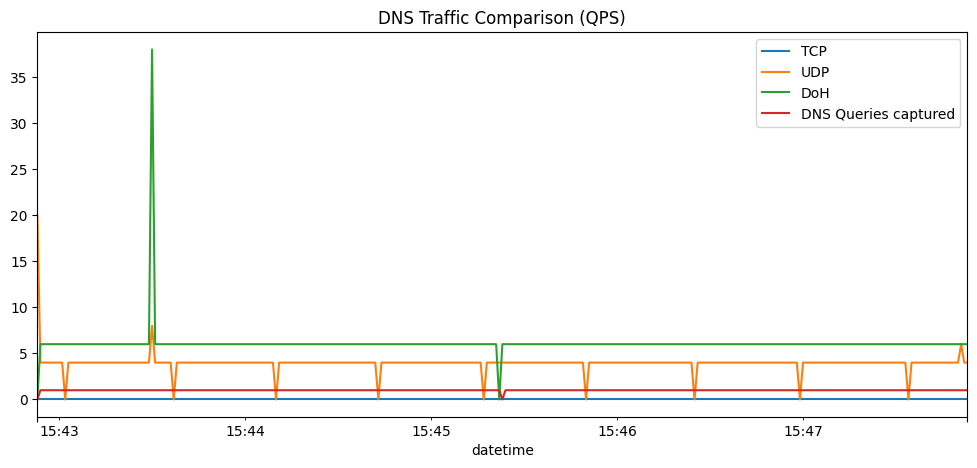

In [14]:
# Resample per second
tcp_qps = dns_tcp_log.resample("1s").size().rename("TCP")
udp_qps = dns_udp_log.resample("1s").size().rename("UDP")
doh_qps = dns_doh_log.resample("1s").size().rename("DoH")
dns_qps = bind_queries_captured_logs.resample("1s").size().rename("DNS Queries captured")

# Merge aligned
combined = pd.concat([tcp_qps, udp_qps, doh_qps, dns_qps], axis=1).fillna(0)

# Plot
combined.plot(figsize=(12, 5), title="DNS Traffic Comparison (QPS)")

## Merge csv files

In [15]:
from functools import reduce

data_frames = [cpu_power, io_power, nic_power, ram_power, yoctowatt]
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['datetime'], how='outer'), data_frames) 
df_merged.head(50)

,Avg_MHz,Busy%,Bzy_MHz,LLCkRPS,LLC%hit,C6%,CoreTmp,PkgTmp,PkgWatt,CorWatt,datetime,read_kB,write_kB,total_kB,rx_bytes,tx_bytes,total_bytes,LLC-loads,LLC-stores,watts
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.000000000,NaN,NaN,NaN,NaN,NaN,NaN,3055166.0,678258.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.711999893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.721999884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.732000113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.742000103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.752000093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.762000084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.772000074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.371
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.782000065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.827
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026-02-16 15:42:53.792000055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.827


### Drop nan values to keep the df with values that each measurements took

In [16]:
dns_tcp_counts = dns_tcp_log.groupby("datetime").size().rename("TCP_queries").reset_index()
dns_udp_counts = dns_udp_log.groupby("datetime").size().rename("UDP_queries").reset_index()
dns_doh_counts = dns_doh_log.groupby("datetime").size().rename("DoH_queries").reset_index()
dns_captured_counts = bind_queries_captured_logs.groupby("datetime").size().rename("Captured_queries").reset_index()

In [17]:
dns_captured_counts.head()

,datetime,Captured_queries
0,2026-02-16 15:42:54.672,1
1,2026-02-16 15:42:55.672,1
2,2026-02-16 15:42:56.676,1
3,2026-02-16 15:42:57.676,1
4,2026-02-16 15:42:58.680,1


In [240]:
dns_frames = [dns_tcp_counts, dns_udp_counts, dns_doh_counts, dns_captured_counts]

# Merge DNS logs together
df_dns = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), dns_frames)

# Merge with df_merged (power / features)
df_full = pd.merge(df_merged, df_dns, on="datetime", how="outer")

# Sort by timestamp
df_full = df_full.sort_values("datetime").reset_index(drop=True)
df_dns.fillna(0, inplace=True)
df_full.head()

,Avg_MHz,Busy%,Bzy_MHz,LLCkRPS,LLC%hit,C6%,CoreTmp,PkgTmp,PkgWatt,CorWatt,...,rx_bytes,tx_bytes,total_bytes,LLC-loads,LLC-stores,watts,TCP_queries,UDP_queries,DoH_queries,Captured_queries
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3055166.0,678258.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37.371,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37.371,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37.371,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37.371,NaN,NaN,NaN,NaN


In [242]:
queries_columns = ["TCP_queries","UDP_queries","DoH_queries","Captured_queries"]
df_full[queries_columns] = df_full[queries_columns].fillna(0)
df_full = df_full.bfill()
df_full.head()

,Avg_MHz,Busy%,Bzy_MHz,LLCkRPS,LLC%hit,C6%,CoreTmp,PkgTmp,PkgWatt,CorWatt,...,rx_bytes,tx_bytes,total_bytes,LLC-loads,LLC-stores,watts,TCP_queries,UDP_queries,DoH_queries,Captured_queries
0,128.0,5.01,2561.0,7973.0,0.0,94.05,44.0,44.0,5.24,1.78,...,4050.0,3628.0,7678.0,3055166.0,678258.0,37.371,0.0,0.0,0.0,0.0
1,128.0,5.01,2561.0,7973.0,0.0,94.05,44.0,44.0,5.24,1.78,...,4050.0,3628.0,7678.0,1985207.0,417749.0,37.371,0.0,0.0,0.0,0.0
2,128.0,5.01,2561.0,7973.0,0.0,94.05,44.0,44.0,5.24,1.78,...,4050.0,3628.0,7678.0,1985207.0,417749.0,37.371,0.0,0.0,0.0,0.0
3,128.0,5.01,2561.0,7973.0,0.0,94.05,44.0,44.0,5.24,1.78,...,4050.0,3628.0,7678.0,1985207.0,417749.0,37.371,0.0,0.0,0.0,0.0
4,128.0,5.01,2561.0,7973.0,0.0,94.05,44.0,44.0,5.24,1.78,...,4050.0,3628.0,7678.0,1985207.0,417749.0,37.371,0.0,0.0,0.0,0.0


## Analysing the data

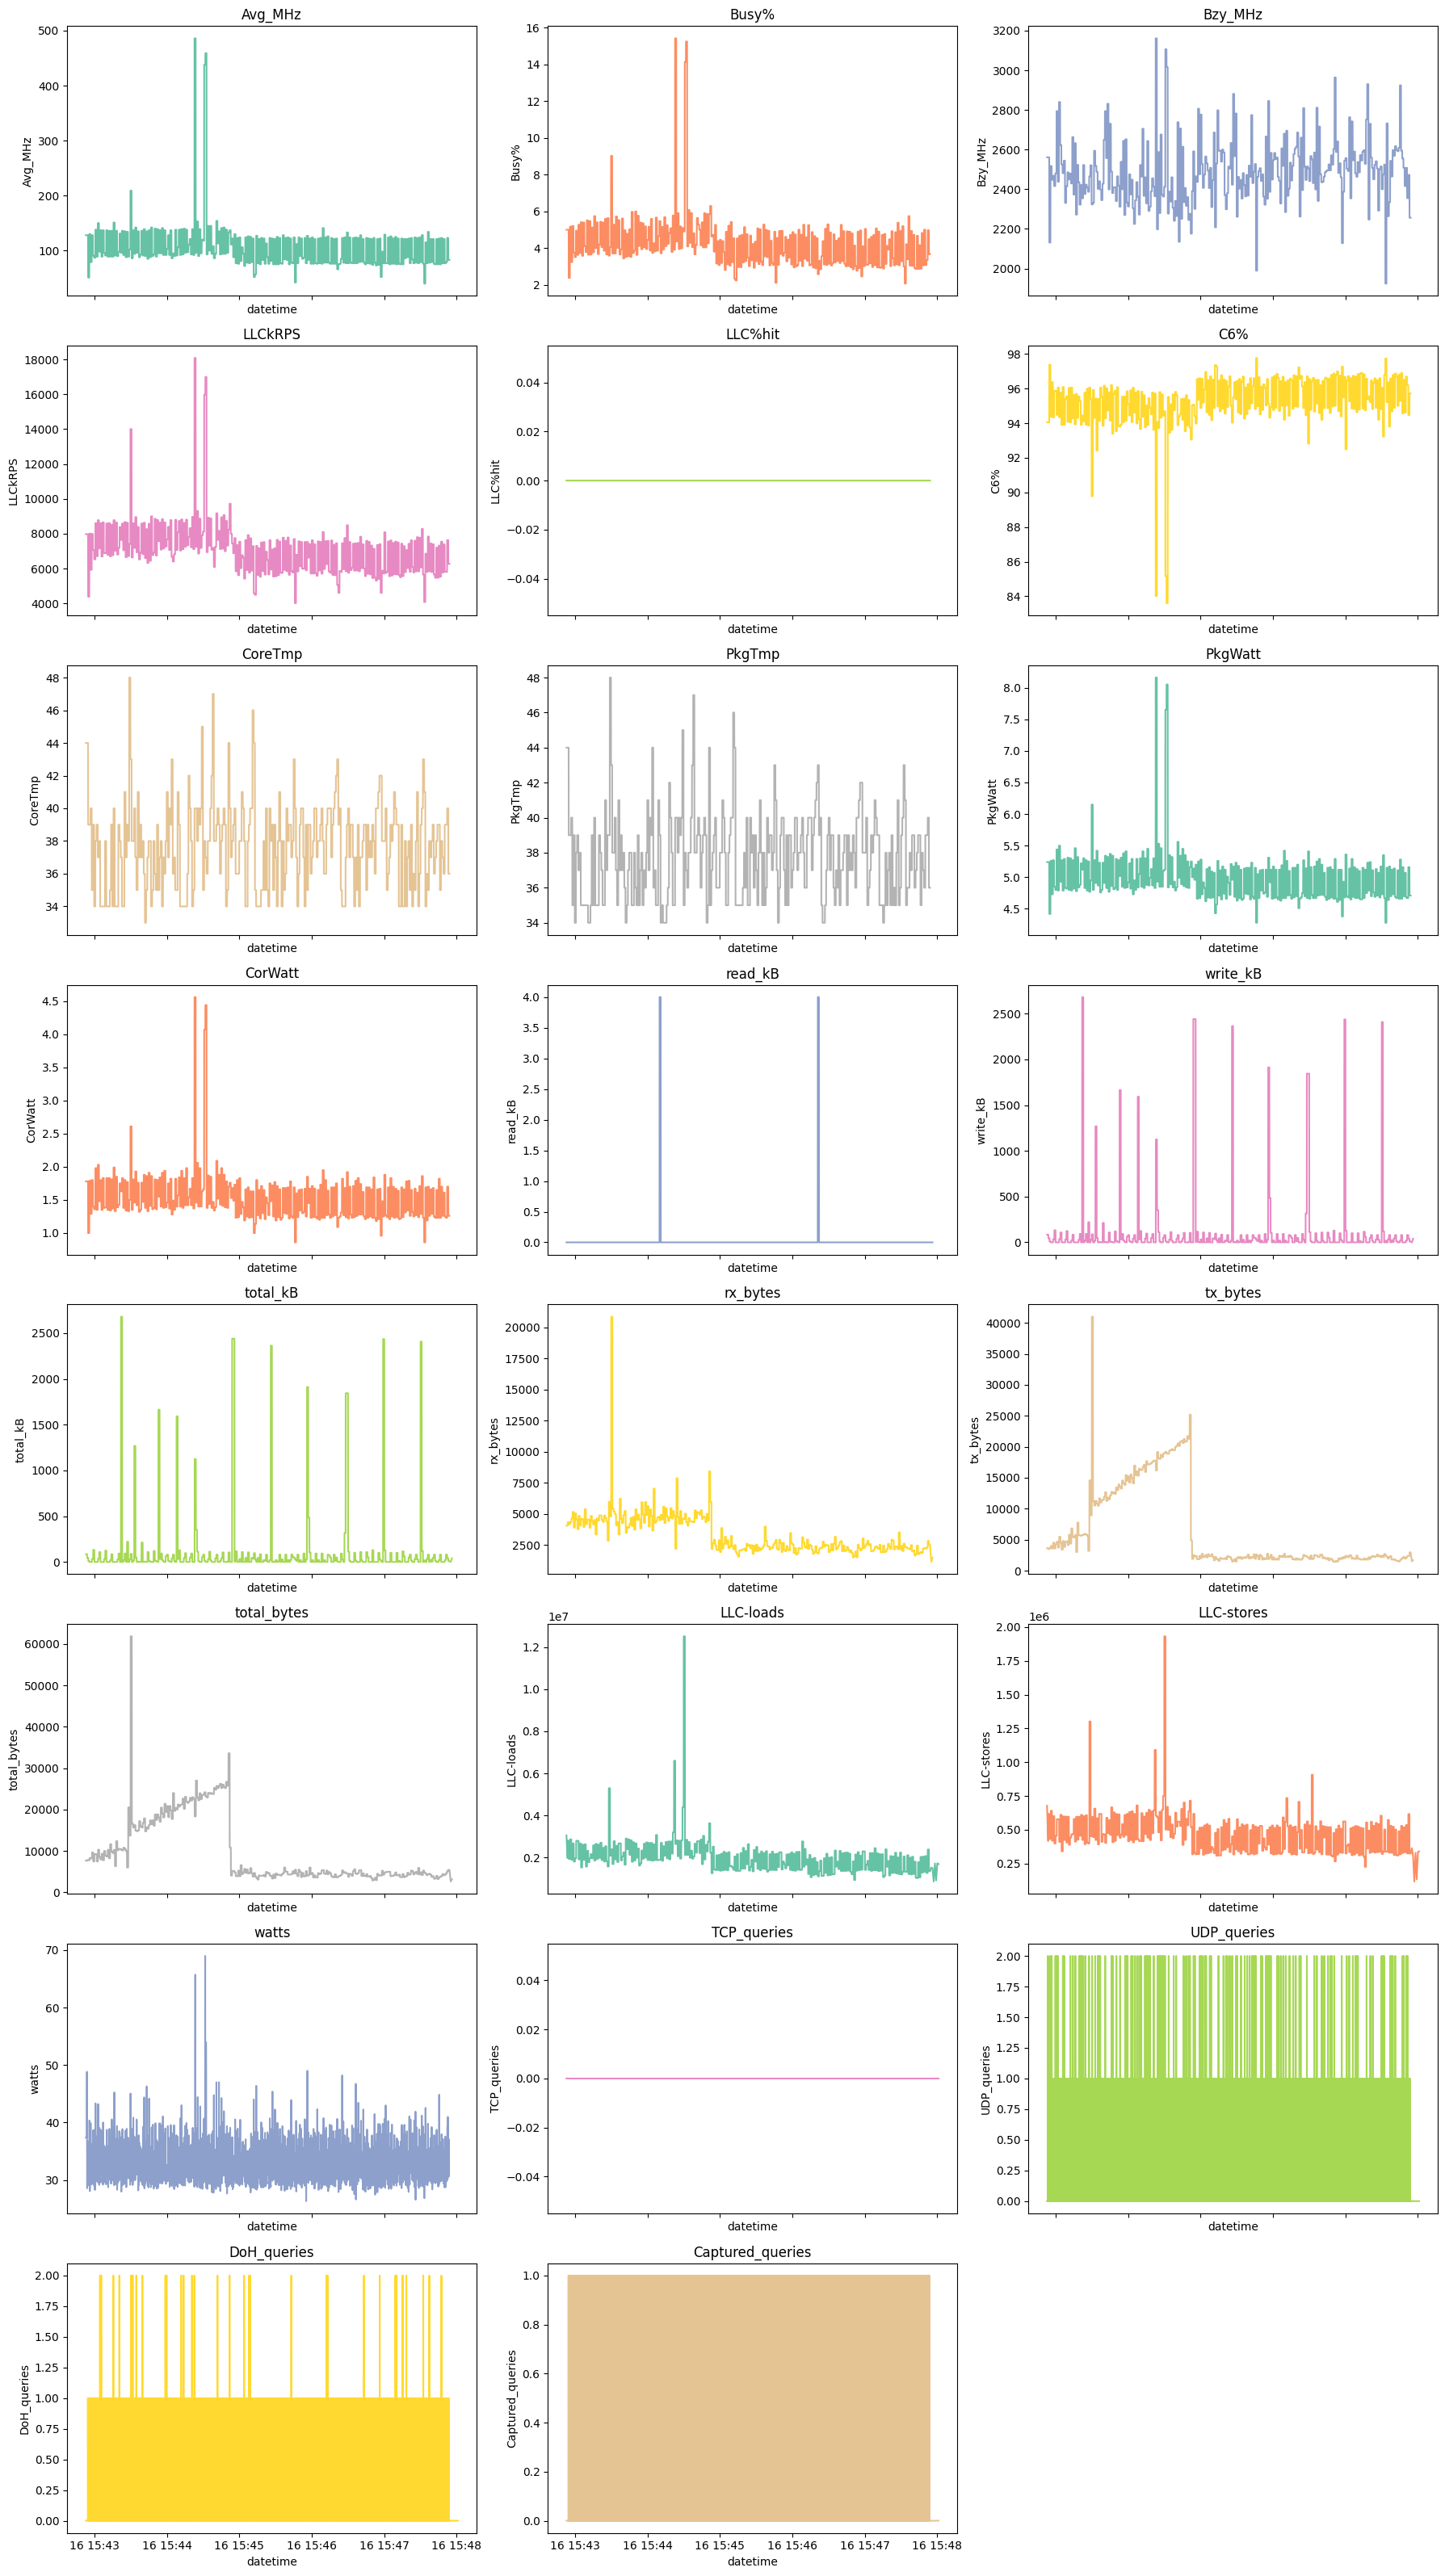

In [243]:
cols = [c for c in df_full.columns if c != "datetime"]
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.ravel(axes)

c = sns.color_palette("Set2", len(cols))
for i, col in enumerate(cols):
    ax = axes[i]
    ax.plot(df_full["datetime"], df_full[col], color=c[i])
    ax.set_title(col)
    ax.set_xlabel("datetime")
    ax.set_ylabel(col)

for j in range(len(cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()

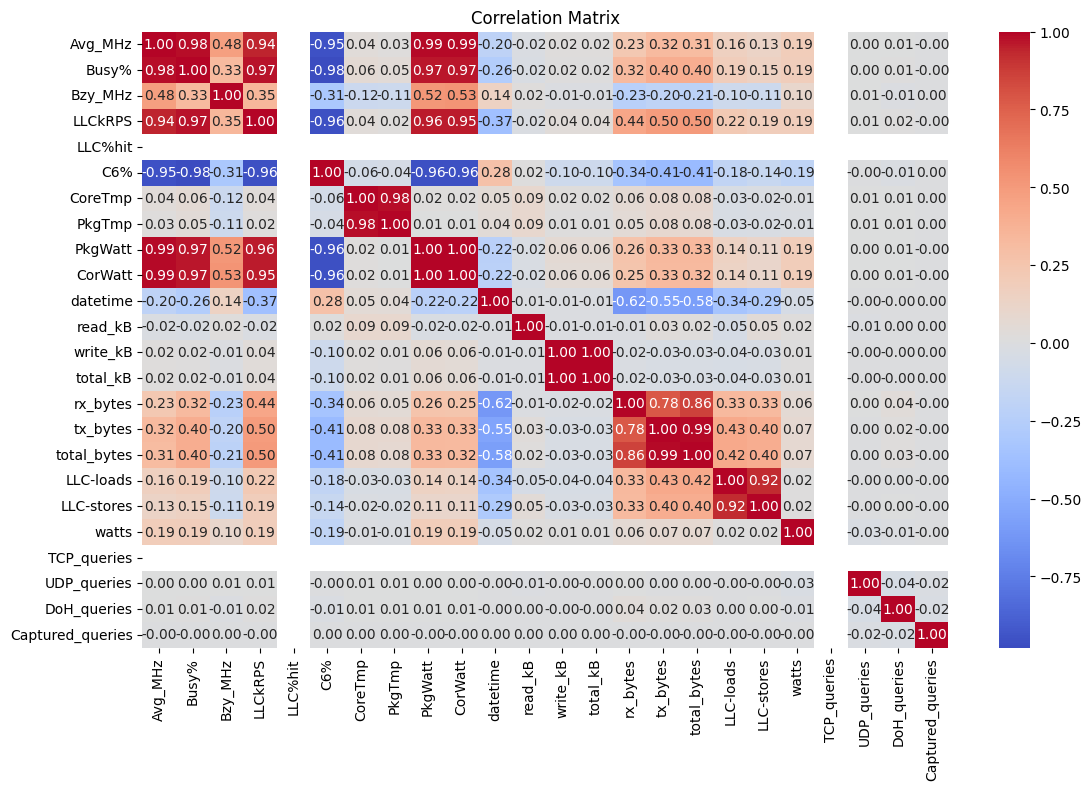

In [248]:
df_full.corr()
plt.figure(figsize=(13, 8)) 
sns.heatmap(df_full.corr(), annot=True, cmap="coolwarm", fmt=".2f") 
plt.title("Correlation Matrix") 
plt.show()

In [249]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [250]:
# --------------------------
# 1. Load your dataset
# --------------------------
# Assume your dataset has a 'datetime' column and 'target' variable
df = df_full.copy()
df = df.rename(columns={"watts": "target"})

# --------------------------
# 2. Feature Engineering
# --------------------------
# Create lag features and rolling statistics
def create_features(df, lags=[1,2,3,6,12], windows=[3,6,12]):
    for lag in lags:
        df[f'lag_{lag}'] = df['target'].shift(lag)
    for window in windows:
        df[f'rolling_mean_{window}'] = df['target'].shift(1).rolling(window).mean()
        df[f'rolling_std_{window}'] = df['target'].shift(1).rolling(window).std()
    df = df.dropna()
    return df

df = create_features(df)

# Separate features and target
X = df.drop(columns=['datetime','target'])
y = df['target']

# --------------------------
# 3. Train-test split
# --------------------------
# Use the last 20% as test set
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# 4a. Random Forest
# --------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_pred)
print(f"Random Forest RMSE: {rf_rmse:.4f}")

# --------------------------
# 4b. XGBoost
# --------------------------
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xg_reg.fit(X_train, y_train)
xgb_pred = xg_reg.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_pred)
print(f"XGBoost RMSE: {xgb_rmse:.4f}")

# --------------------------
# 4c. Linear Regression
# --------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_pred)
print(f"Linear Regression RMSE: {lr_rmse:.4f}")

# --------------------------
# 4d. LSTM
# --------------------------
# Reshape for LSTM: [samples, timesteps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(X_train_lstm, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_rmse = mean_squared_error(y_test, lstm_pred)
print(f"LSTM RMSE: {lstm_rmse:.4f}")

# --------------------------
# 5. Compare results
# --------------------------
results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "Linear Regression", "LSTM"],
    "RMSE": [rf_rmse, xgb_rmse, lr_rmse, lstm_rmse]
})
print(results)

Random Forest RMSE: 1.1413
XGBoost RMSE: 1.1064
Linear Regression RMSE: 1.1602


c:\Fernand\programmation\dns-activity-monitoring\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM RMSE: 1.2761
               Model      RMSE
0      Random Forest  1.141272
1            XGBoost  1.106449
2  Linear Regression  1.160176
3               LSTM  1.276064


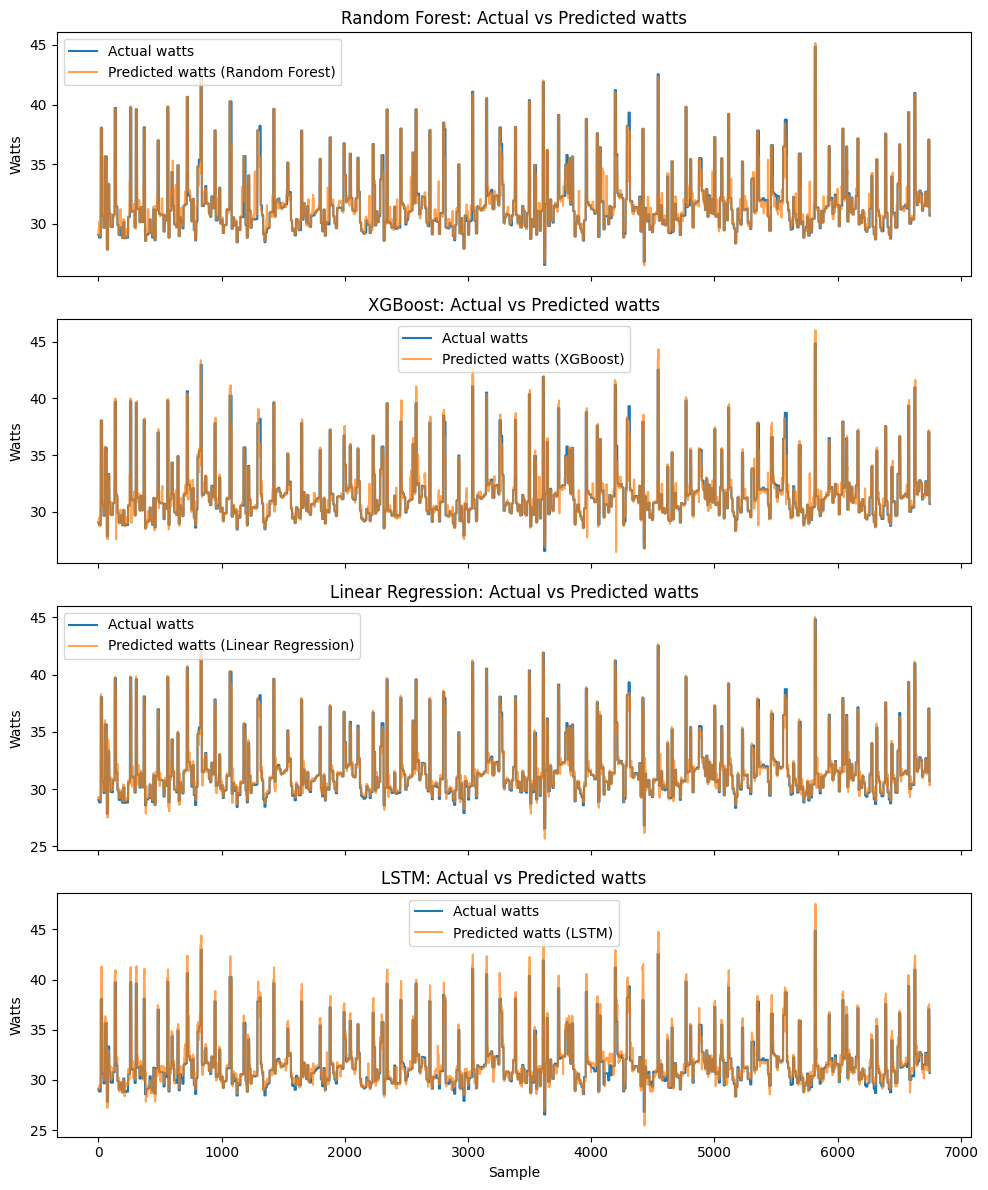

In [254]:
y_test.reset_index(drop=True, inplace=True)

# Plot Actual vs Predicted for all models
preds = {
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "Linear Regression": lr_pred,
    "LSTM": lstm_pred.ravel(),
}

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
for ax, (name, pred) in zip(axes, preds.items()):
    ax.plot(y_test, label="Actual watts")
    ax.plot(pred, label=f"Predicted watts ({name})", alpha=0.7)
    ax.set_title(f"{name}: Actual vs Predicted watts")
    ax.set_ylabel("Watts")
    ax.legend()

axes[-1].set_xlabel("Sample")
plt.tight_layout()
plt.show()


In [255]:
# Linear regression model:
# y = β0 + β1*x1 + β2*x2 + ... + βp*xp + ε
# Fitted coefficients (β) and intercept (β0) from training:
print(f"β0 (intercept) = {lr.intercept_}")
print(f"β (coefficients) = {lr.coef_}")

β0 (intercept) = 9.678721744460798
β (coefficients) = [ 4.09899833e-04 -6.62499261e-02 -1.94094222e-05  1.99645481e-05
 -1.20971701e-12 -4.22081726e-02 -1.08901149e-02  7.22377960e-03
 -5.26945760e-01  6.71607194e-01  1.89182879e-02 -9.46027807e-03
  9.45800995e-03  1.63116803e-06 -6.58934418e-07  9.72703387e-07
 -1.55378918e-08  4.98971484e-08  1.72084569e-15 -1.66203802e-02
  1.07333231e-02  1.64692458e-01  8.27828982e-01 -4.61567486e-02
 -7.80064197e-02  3.16713105e-02  1.42554130e-01  2.34555271e-01
  2.89762664e-02  2.34825959e-01  1.00832545e-01 -4.67977137e-01
 -1.08246074e-02]


In [256]:
# MAPE for Linear Regression predictions
lr_mape = (np.abs(y_test - lr_pred) / np.abs(y_test)).mean() * 100
print(f"Linear Regression MAPE: {lr_mape:.2f}%")

Linear Regression MAPE: 1.14%


In [257]:
# MAPE for XGBoost predictions
xgb_mape = (np.abs(y_test - xgb_pred) / np.abs(y_test)).mean() * 100
print(f"XGBoost MAPE: {xgb_mape:.2f}%")

XGBoost MAPE: 1.20%


## Desagregation attempt

Index(['Avg_MHz', 'Busy%', 'Bzy_MHz', 'LLCkRPS', 'LLC%hit', 'C6%', 'CoreTmp',
       'PkgTmp', 'PkgWatt', 'CorWatt', 'timestamp', 'read_kB', 'write_kB',
       'total_kB', 'rx_bytes', 'tx_bytes', 'total_bytes', 'LLC-loads',
       'LLC-stores', 'watts'],
      dtype='object')
['Avg_MHz', 'Busy%', 'Bzy_MHz', 'LLCkRPS', 'LLC%hit', 'C6%', 'CoreTmp', 'PkgTmp', 'PkgWatt', 'CorWatt', 'timestamp', 'read_kB', 'write_kB', 'total_kB', 'rx_bytes', 'tx_bytes', 'total_bytes', 'LLC-loads', 'LLC-stores']
RMSE for Avg_MHz: 780.0515
RMSE for Busy%: 1.1674
RMSE for Bzy_MHz: 18476.6021
RMSE for LLCkRPS: 1027578.7064
RMSE for LLC%hit: 0.0000
RMSE for C6%: 1.4188
RMSE for CoreTmp: 8.3005
RMSE for PkgTmp: 6.8910
RMSE for PkgWatt: 0.0820
RMSE for CorWatt: 0.0738
RMSE for timestamp: 22688.1807
RMSE for read_kB: 0.0000
RMSE for write_kB: 49183.8544
RMSE for total_kB: 49183.8544
RMSE for rx_bytes: 1077700.0584
RMSE for tx_bytes: 1816478.3740
RMSE for total_bytes: 5399492.7320
RMSE for LLC-loads: 190485027325.11

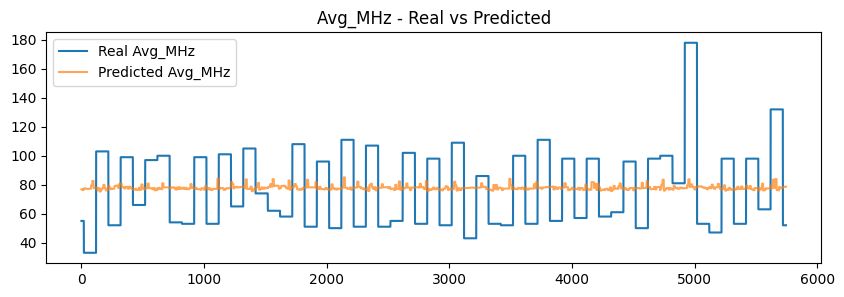

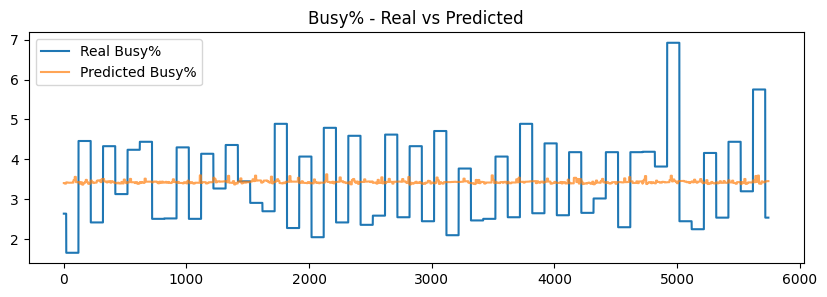

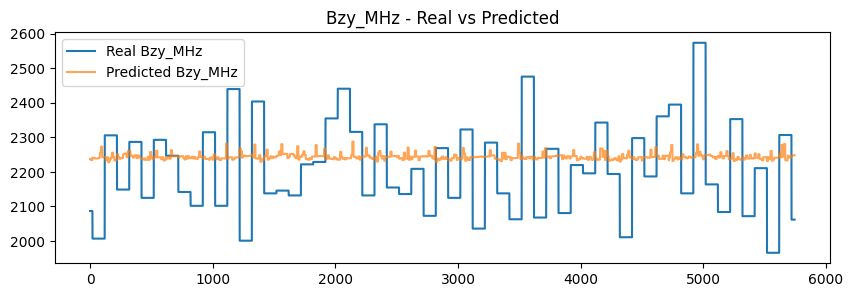

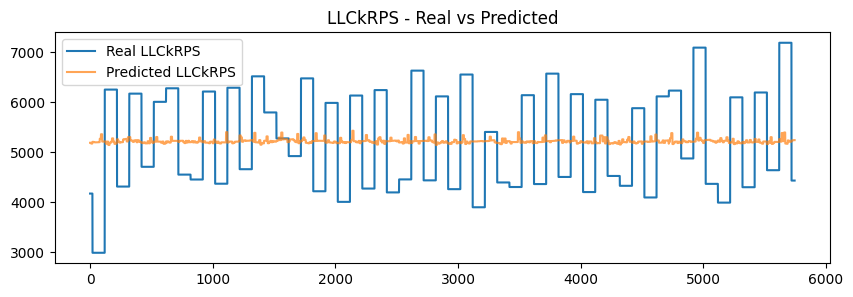

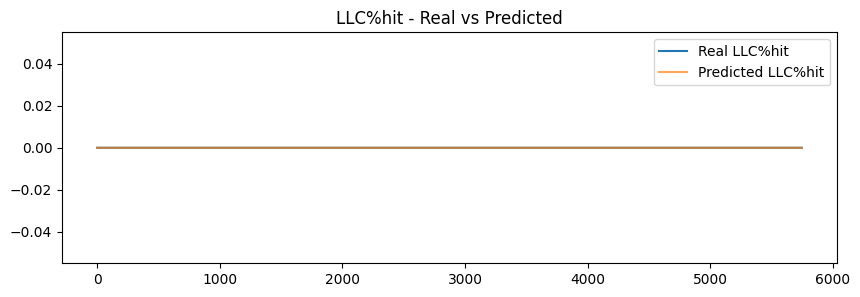

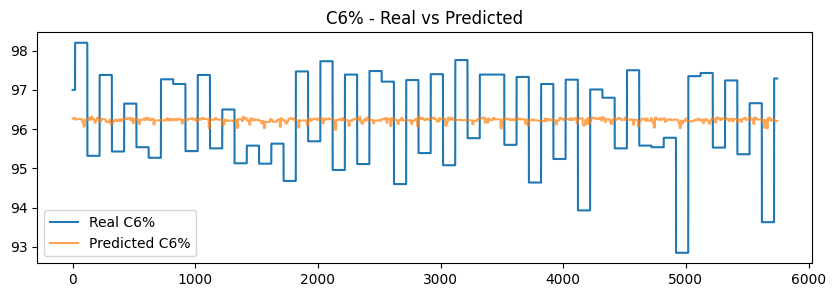

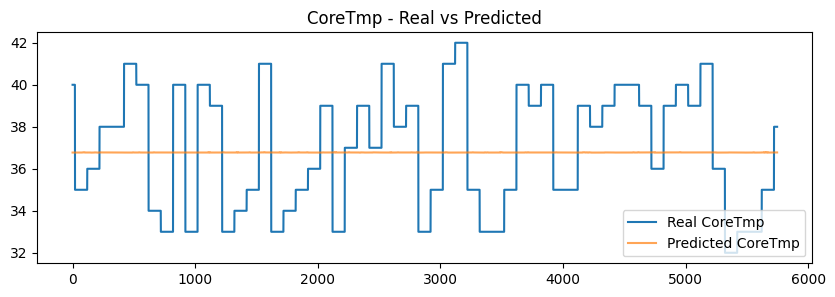

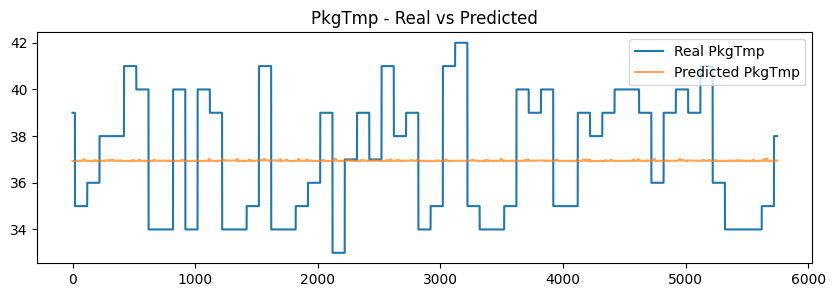

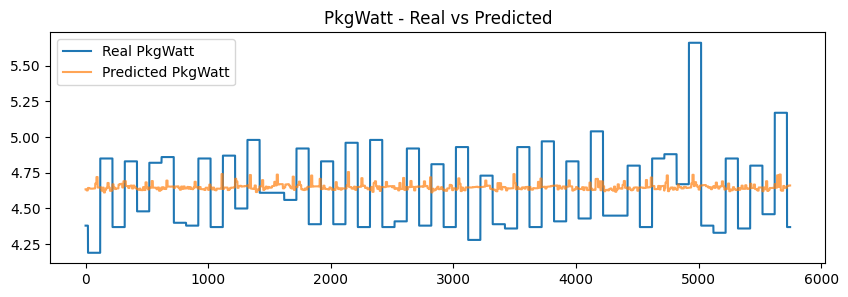

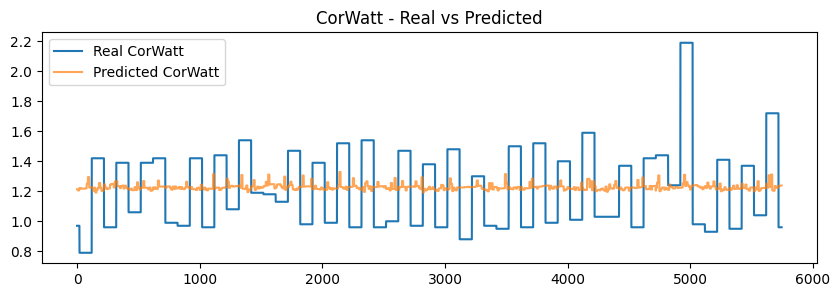

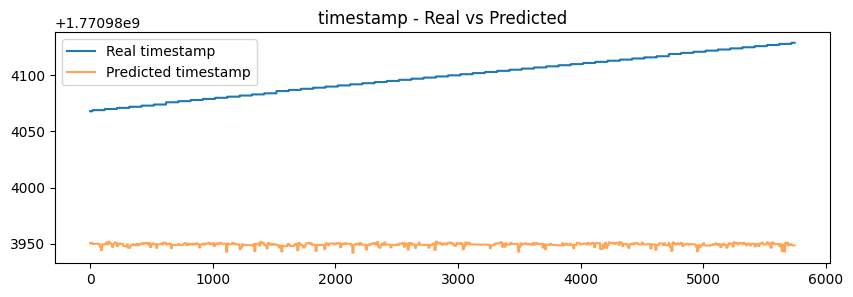

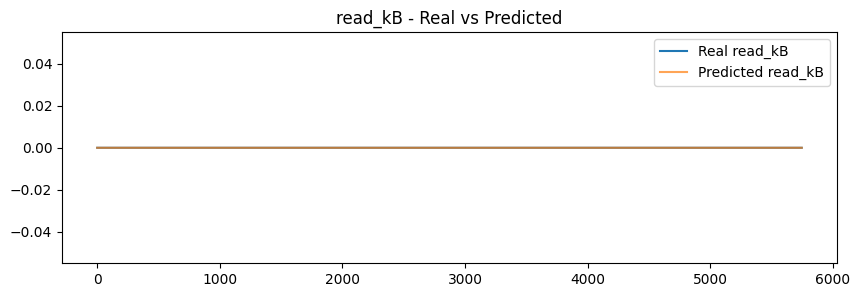

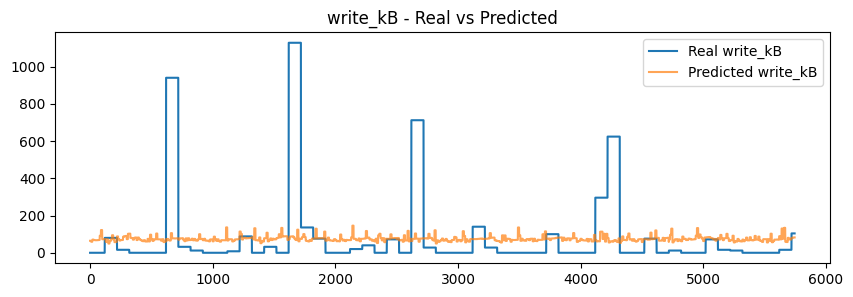

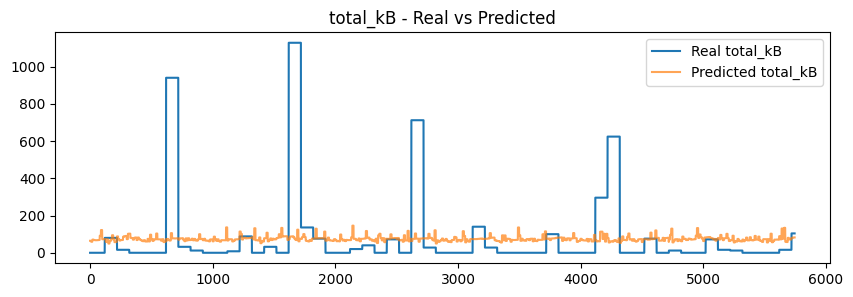

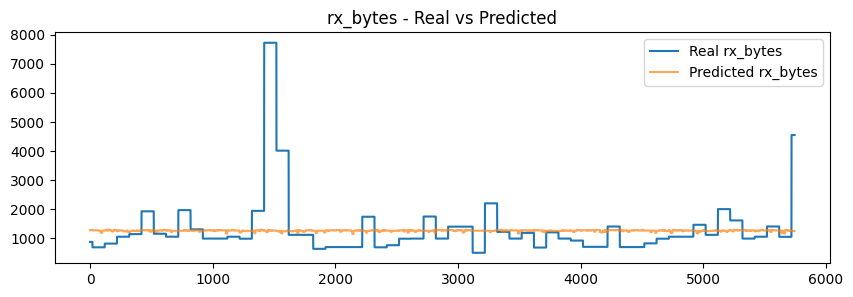

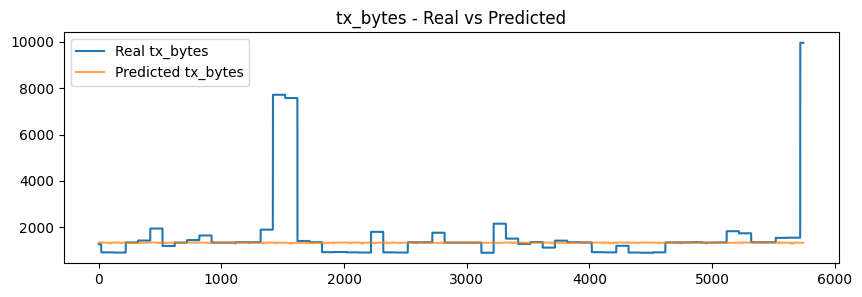

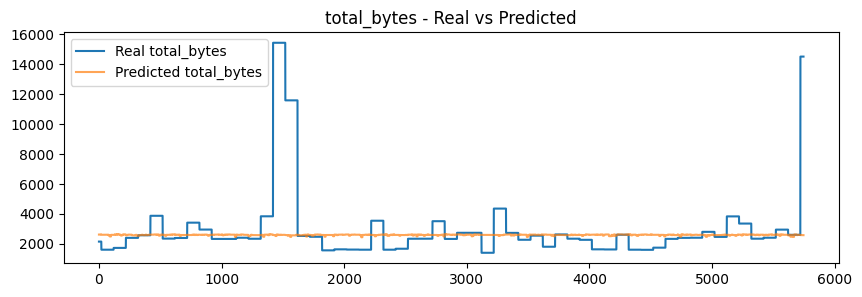

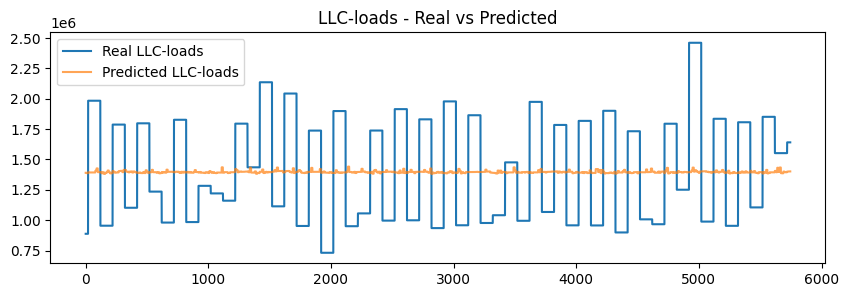

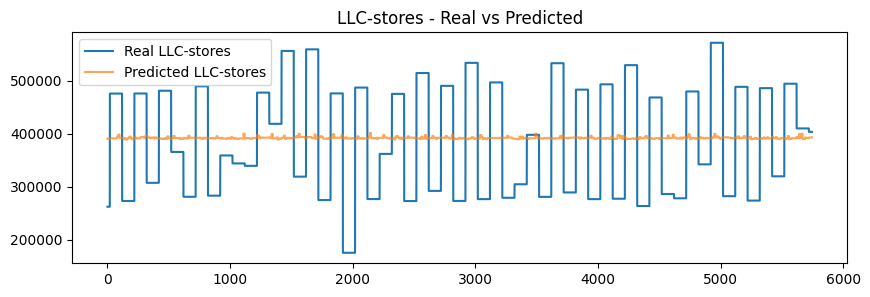

In [81]:
# --------------------------
# Imports
# --------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare features and targets
# --------------------------
df = df_merged.copy()

# Feature: total watts
X = df[['watts']]  

# Targets: individual component consumptions
print(df.columns)
component_cols = [c for c in df.columns if c != 'watts']
y = df[component_cols]
print(component_cols)
# Train-test split (chronological)
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --------------------------
# 2. Train Linear Regression for each component
# --------------------------
component_preds = pd.DataFrame(index=y_test.index)

for col in component_cols:
    model = LinearRegression()
    model.fit(X_train, y_train[col])
    component_preds[col] = model.predict(X_test)
    rmse = mean_squared_error(y_test[col], component_preds[col])
    print(f"RMSE for {col}: {rmse:.4f}")

# --------------------------
# 3. Compare total prediction vs actual watts
# --------------------------
component_preds['total_pred'] = component_preds.sum(axis=1)
rmse_total = mean_squared_error(df['watts'].iloc[split_idx:], component_preds['total_pred'])
print(f"Total predicted watts RMSE: {rmse_total:.4f}")

# --------------------------
# 4. Plot real vs predicted for each component
# --------------------------

for col in component_cols:
    plt.figure(figsize=(10,3))
    plt.plot(y_test[col].values, label=f'Real {col}')
    plt.plot(component_preds[col].values, label=f'Predicted {col}', alpha=0.7)
    plt.title(f'{col} - Real vs Predicted')
    plt.legend()
    plt.show()
